import libraries

In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from collections import defaultdict

read data into pd

In [2]:
data = pd.read_csv('email_with_predicted_roles_V2.csv')
# data = data.drop(columns=['Content','Total_Sentence_Word_Count','From_Names','To_Names','Cleaned_Content','BoW','DateTime'])


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 381581 entries, 0 to 381580
Data columns (total 13 columns):
 #   Column                     Non-Null Count   Dtype 
---  ------                     --------------   ----- 
 0   From                       381581 non-null  object
 1   To                         381581 non-null  object
 2   Subject                    381581 non-null  object
 3   X-cc                       381581 non-null  object
 4   X-bcc                      381581 non-null  object
 5   Content                    381581 non-null  object
 6   Job_Title                  381581 non-null  object
 7   Total_Sentence_Word_Count  381581 non-null  int64 
 8   From_Names                 381581 non-null  object
 9   To_Names                   377376 non-null  object
 10  Cleaned_Content            381581 non-null  object
 11  BoW                        381581 non-null  object
 12  DateTime                   381581 non-null  object
dtypes: int64(1), object(12)
memory usage: 37.8+ 

preprocess the data to remove weird and non-enron emails
- initially there are about 19k unique entries under From column

In [5]:
data['From'] = data['From'].str.strip().replace('', pd.NA)
data = data.dropna(subset=['From'])

# Filter rows where 'From' ends with '@enron.com' and does not contain numbers before '@enron.com'
filtered_data = data[
    data['From'].str.contains('@enron\.com$', na=False, regex=True) &  # Ends with '@enron.com'
    ~data['From'].str.contains(r'\d+@enron\.com$', na=False, regex=True)  # Does not contain numbers before '@enron.com'
]

<>:6: SyntaxWarning: invalid escape sequence '\.'
<>:6: SyntaxWarning: invalid escape sequence '\.'
C:\Users\Yap Yee Peng\AppData\Local\Temp\ipykernel_18984\710275862.py:6: SyntaxWarning: invalid escape sequence '\.'
  data['From'].str.contains('@enron\.com$', na=False, regex=True) &  # Ends with '@enron.com'


In [6]:
filtered_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 381581 entries, 0 to 381580
Data columns (total 13 columns):
 #   Column                     Non-Null Count   Dtype 
---  ------                     --------------   ----- 
 0   From                       381581 non-null  object
 1   To                         381581 non-null  object
 2   Subject                    381581 non-null  object
 3   X-cc                       381581 non-null  object
 4   X-bcc                      381581 non-null  object
 5   Content                    381581 non-null  object
 6   Job_Title                  381581 non-null  object
 7   Total_Sentence_Word_Count  381581 non-null  int64 
 8   From_Names                 381581 non-null  object
 9   To_Names                   377376 non-null  object
 10  Cleaned_Content            381581 non-null  object
 11  BoW                        381581 non-null  object
 12  DateTime                   381581 non-null  object
dtypes: int64(1), object(12)
memory usage: 37.8+ 

In [14]:
filtered_data

,From,To,Subject,X-cc,X-bcc,Job_Title
0,richard.shapiro@enron.com,leslie.lawner@enron.com,Re: Talking points about California Gas market,"Christi L Nicolay, Joe Hartsoe, Rebecca W Cant...",X-Folder: \Phillip_Allen_Dec2000\Notes Folders...,"Vice President, Regulatory Affairs"
1,keith.holst@enron.com,k..allen@enron.com,FW: must see,X-bcc:,"X-Folder: \PALLEN (Non-Privileged)\Allen, Phil...",Director
2,john.lavorato@enron.com,k..allen@enron.com,RE: Chase Backtest,X-bcc:,"X-Folder: \Phillip_Allen_Jan2002_1\Allen, Phil...","CEO, Enron America"
3,louise.kitchen@enron.com,"wes.colwell@enron.com, georgeanne.hodges@enron...",NETCO,"Lavorato, John </O=ENRON/OU=NA/CN=RECIPIENTS/C...","X-Folder: \Phillip_Allen_Jan2002_1\Allen, Phil...","President, Enron Online"
4,louise.kitchen@enron.com,"tim.belden@enron.com, f..calger@enron.com, m.....",Re-start/Integration Planning,"Lavorato, John </O=ENRON/OU=NA/CN=RECIPIENTS/C...","X-Folder: \Phillip_Allen_Jan2002_1\Allen, Phil...","President, Enron Online"
...,...,...,...,...,...,...
381576,john.zufferli@enron.com,kori.loibl@enron.com,Trade with John Lavorato,X-bcc:,"X-Folder: \ExMerge - Zufferli, John\Sent Items",Vice President
381577,john.zufferli@enron.com,john.lavorato@enron.com,Gas Hedges,X-bcc:,"X-Folder: \ExMerge - Zufferli, John\Sent Items",Vice President
381578,john.zufferli@enron.com,dawn.doucet@enron.com,RE: CONFIDENTIAL,X-bcc:,"X-Folder: \ExMerge - Zufferli, John\Sent Items","CEO, Enron America"
381579,john.zufferli@enron.com,jeanie.slone@enron.com,Calgary Analyst/Associate,X-bcc:,"X-Folder: \ExMerge - Zufferli, John\Sent Items",Analyst Risk Management


In [7]:
# Split the 'To' column into a list of recipients
filtered_data['To'] = filtered_data['To'].str.split(',')

filtered_data = filtered_data.explode('To')

filtered_data = filtered_data.dropna(subset=['From', 'To'])

filtered_data['From'] = filtered_data['From'].str.strip()
filtered_data['To'] = filtered_data['To'].str.strip()

filtered_data = filtered_data[filtered_data['From'].str.contains('@', na=False)]
filtered_data = filtered_data[filtered_data['To'].str.contains('@', na=False)]

filtered_data['To'] = filtered_data['To'].str.strip().replace('', pd.NA)
filtered_data = filtered_data.dropna(subset=['To'])

filtered_data_2 = filtered_data[
    filtered_data['To'].str.contains('@enron\.com$', na=False, regex=True) &
    ~filtered_data['To'].str.contains(r'\d+@enron\.com$', na=False, regex=True)
]


filtered_data_2.info()

<>:18: SyntaxWarning: invalid escape sequence '\.'
<>:18: SyntaxWarning: invalid escape sequence '\.'
C:\Users\Yap Yee Peng\AppData\Local\Temp\ipykernel_18984\3051118151.py:18: SyntaxWarning: invalid escape sequence '\.'
  filtered_data['To'].str.contains('@enron\.com$', na=False, regex=True) &


<class 'pandas.core.frame.DataFrame'>
Index: 489586 entries, 0 to 381579
Data columns (total 13 columns):
 #   Column                     Non-Null Count   Dtype 
---  ------                     --------------   ----- 
 0   From                       489586 non-null  object
 1   To                         489586 non-null  object
 2   Subject                    489586 non-null  object
 3   X-cc                       489586 non-null  object
 4   X-bcc                      489586 non-null  object
 5   Content                    489586 non-null  object
 6   Job_Title                  489586 non-null  object
 7   Total_Sentence_Word_Count  489586 non-null  int64 
 8   From_Names                 489586 non-null  object
 9   To_Names                   489568 non-null  object
 10  Cleaned_Content            489586 non-null  object
 11  BoW                        489586 non-null  object
 12  DateTime                   489586 non-null  object
dtypes: int64(1), object(12)
memory usage: 52.3+ MB


prepare node edges + create foundation for graph
- using From and To columns only, that will match with Job_Title later on

In [8]:
edges = filtered_data_2[['From', 'To']]

In [9]:
# Create a directed graph
G = nx.DiGraph()

# Add edges from the DataFrame
for _, row in edges.iterrows():
    G.add_edge(row['From'], row['To'])

1. Calculate degree centrality
- node's importance by counting the number of direct connetions (edges) it has to other nodes

In [10]:
degree_centrality = nx.degree_centrality(G)

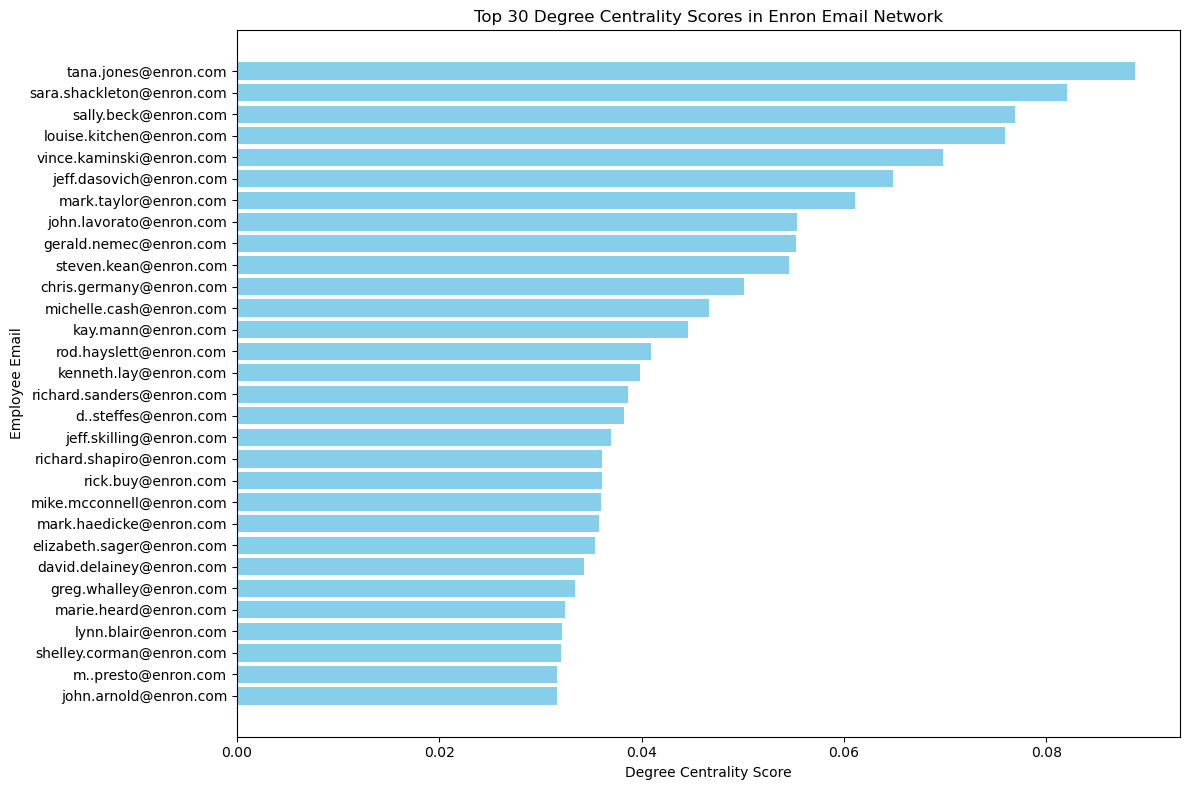

In [11]:
# Sort nodes by degree centrality scores in descending order
sorted_degree_centrality = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)

# Get the top 30 nodes with the highest degree centrality
top_30 = sorted_degree_centrality[:30]

# Extract names and scores for the bar graph
names = [x[0] for x in top_30]
scores = [x[1] for x in top_30]

plt.figure(figsize=(12, 8))
plt.barh(names, scores, color='skyblue')
plt.xlabel('Degree Centrality Score')
plt.ylabel('Employee Email')
plt.title('Top 30 Degree Centrality Scores in Enron Email Network')
plt.gca().invert_yaxis()
plt.tight_layout()

plt.show()

In [12]:
# Extract email addresses of the top 30
top_30_emails = [x[0] for x in top_30]

# Create a dictionary to store email-job_title pairs
email_to_job_title = {}

# Look through the entire 'From' list and match with the top 20 emails
for email in top_30_emails:
    job_title = data.loc[data['From'] == email, 'Job_Title'].drop_duplicates().values
    if len(job_title) > 0:
        email_to_job_title[email] = job_title[0]
    else:
        email_to_job_title[email] = 'Unknown'

top_30_with_titles = pd.DataFrame(top_30, columns=['email', 'degree_centrality'])
top_30_with_titles['Job_Title'] = top_30_with_titles['email'].map(email_to_job_title)

top_30_with_titles.head(30)

,email,degree_centrality,Job_Title
0,tana.jones@enron.com,0.088765,Vice President
1,sara.shackleton@enron.com,0.081998,Vice President
2,sally.beck@enron.com,0.076923,Chief Operating Officer
3,louise.kitchen@enron.com,0.075928,"President, Enron Online"
4,vince.kaminski@enron.com,0.069758,"Manager, Risk Management Head"
5,jeff.dasovich@enron.com,0.064882,Government Relation Executive
6,mark.taylor@enron.com,0.061101,"Managing Director, Legal Department"
7,john.lavorato@enron.com,0.055329,"CEO, Enron America"
8,gerald.nemec@enron.com,0.055229,Vice President
9,steven.kean@enron.com,0.054533,"Vice President, Vice President & Chief of Staff"


1.2 in-degree centrality
- <i>In-degree: No. of emails received
- <i>High in-degree - authority figures

In [13]:
in_degree_centrality = nx.in_degree_centrality(G)

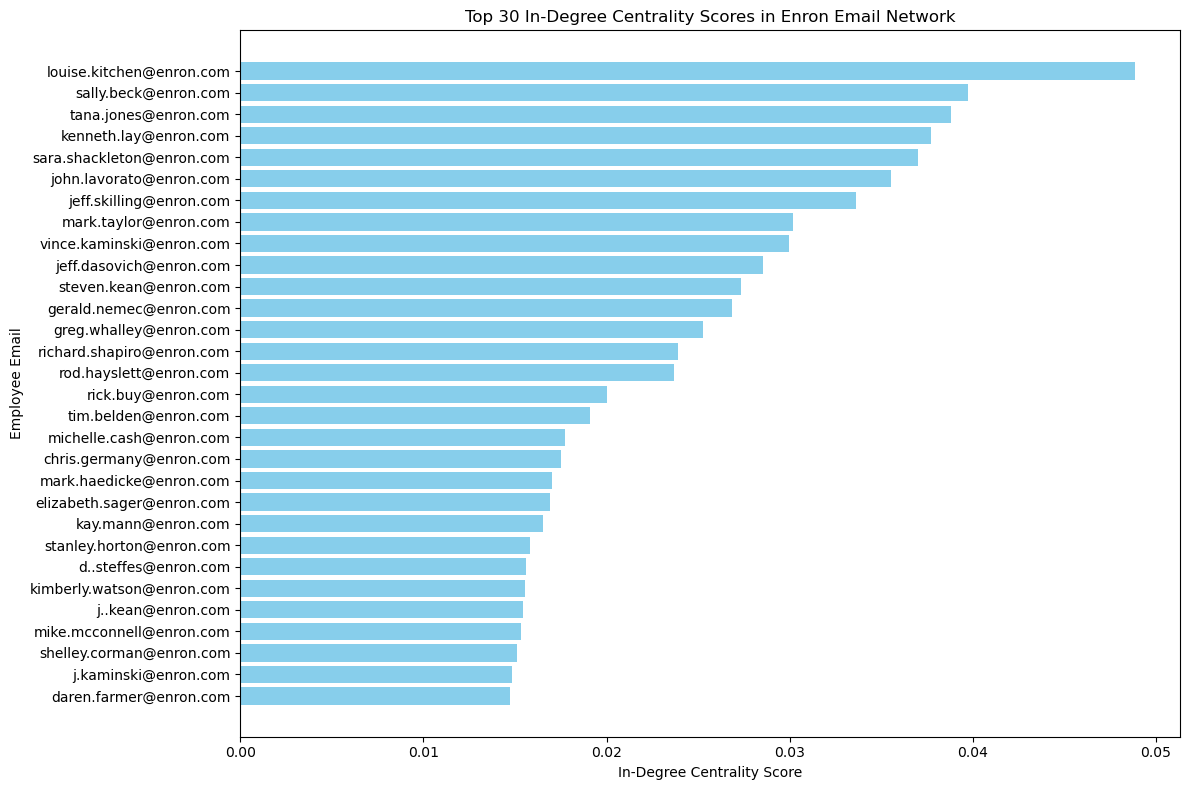

In [14]:
# Sort nodes by degree centrality scores in descending order
sorted_in_degree_centrality = sorted(in_degree_centrality.items(), key=lambda x: x[1], reverse=True)

# Get the top 30 nodes with the highest degree centrality
in_degree_top_30 = sorted_in_degree_centrality[:30]

# Extract names and scores for the bar graph
in_names = [x[0] for x in in_degree_top_30]
in_scores = [x[1] for x in in_degree_top_30]

plt.figure(figsize=(12, 8))
plt.barh(in_names, in_scores, color='skyblue')
plt.xlabel('In-Degree Centrality Score')
plt.ylabel('Employee Email')
plt.title('Top 30 In-Degree Centrality Scores in Enron Email Network')
plt.gca().invert_yaxis()
plt.tight_layout()

plt.show()

In [15]:
# Extract email addresses of the top 30
in_top_30_emails = [x[0] for x in in_degree_top_30]

# Create a dictionary to store email-job_title pairs
in_email_to_job_title = {}

# Look through the entire 'From' list and match with the top 20 emails
for email in in_top_30_emails:
    job_title = data.loc[data['From'] == email, 'Job_Title'].drop_duplicates().values
    if len(job_title) > 0:
        in_email_to_job_title[email] = job_title[0]
    else:
        in_email_to_job_title[email] = 'Unknown'

in_top_30_with_titles = pd.DataFrame(in_degree_top_30, columns=['email', 'in_degree_centrality'])
in_top_30_with_titles['Job_Title'] = in_top_30_with_titles['email'].map(in_email_to_job_title)

in_top_30_with_titles.head(30)

,email,in_degree_centrality,Job_Title
0,louise.kitchen@enron.com,0.048861,"President, Enron Online"
1,sally.beck@enron.com,0.039705,Chief Operating Officer
2,tana.jones@enron.com,0.038810,Vice President
3,kenneth.lay@enron.com,0.037715,CEO
4,sara.shackleton@enron.com,0.037019,Vice President
5,john.lavorato@enron.com,0.035526,"CEO, Enron America"
6,jeff.skilling@enron.com,0.033635,Government Relation Executive
7,mark.taylor@enron.com,0.030152,"Managing Director, Legal Department"
8,vince.kaminski@enron.com,0.029953,"Manager, Risk Management Head"
9,jeff.dasovich@enron.com,0.028560,Government Relation Executive


1.3 out-degree centrality
- <i>Out-degree: No. of emails sent<i>
- <i>High out-degree - information spreaders<i>

In [16]:
out_degree_centrality = nx.out_degree_centrality(G)

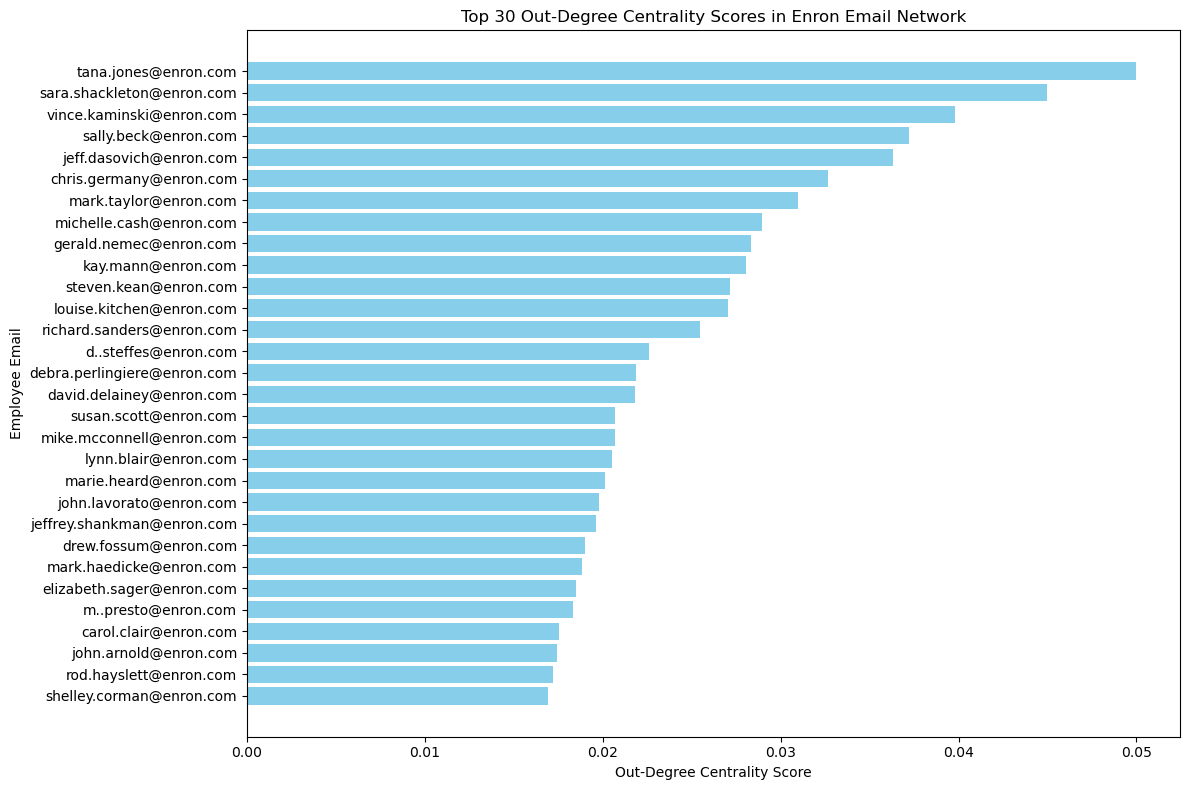

In [17]:
# Sort nodes by degree centrality scores in descending order
sorted_out_degree_centrality = sorted(out_degree_centrality.items(), key=lambda x: x[1], reverse=True)

# Get the top 30 nodes with the highest degree centrality
out_degree_top_30 = sorted_out_degree_centrality[:30]

# Extract names and scores for the bar graph
out_names = [x[0] for x in out_degree_top_30]
out_scores = [x[1] for x in out_degree_top_30]

plt.figure(figsize=(12, 8))
plt.barh(out_names, out_scores, color='skyblue')
plt.xlabel('Out-Degree Centrality Score')
plt.ylabel('Employee Email')
plt.title('Top 30 Out-Degree Centrality Scores in Enron Email Network')
plt.gca().invert_yaxis()
plt.tight_layout()

plt.show()

In [19]:
# Extract email addresses of the top 30
out_top_30_emails = [x[0] for x in out_degree_top_30]

out_email_to_job_title = {}

for email in out_top_30_emails:
    job_title = data.loc[data['From'] == email, 'Job_Title'].drop_duplicates().values
    if len(job_title) > 0:
        out_email_to_job_title[email] = job_title[0]
    else:
        out_email_to_job_title[email] = 'Unknown'

out_top_30_with_titles = pd.DataFrame(out_degree_top_30, columns=['email', 'out_degree_centrality'])
out_top_30_with_titles['Job_Title'] = out_top_30_with_titles['email'].map(out_email_to_job_title)

out_top_30_with_titles.head(30)

,email,out_degree_centrality,Job_Title
0,tana.jones@enron.com,0.049955,Vice President
1,sara.shackleton@enron.com,0.044980,Vice President
2,vince.kaminski@enron.com,0.039805,"Manager, Risk Management Head"
3,sally.beck@enron.com,0.037218,Chief Operating Officer
4,jeff.dasovich@enron.com,0.036322,Government Relation Executive
5,chris.germany@enron.com,0.032640,Vice President
6,mark.taylor@enron.com,0.030948,"Managing Director, Legal Department"
7,michelle.cash@enron.com,0.028958,Administrative Assistant
8,gerald.nemec@enron.com,0.028361,Vice President
9,kay.mann@enron.com,0.028062,Vice President


2. Calculate betweenness centrality
- <i>Betweenness centrality identifies individuals who act as bridges between different groups.<i>
- <i>Can be critical connectors in the network<i>
- <i>Highlighs bottlenecks and key intermediaries, may be essential for information flow and collaboration across departments<i>

In [20]:
betweenness_centrality = nx.betweenness_centrality(G, normalized=True)  # Normalized by default

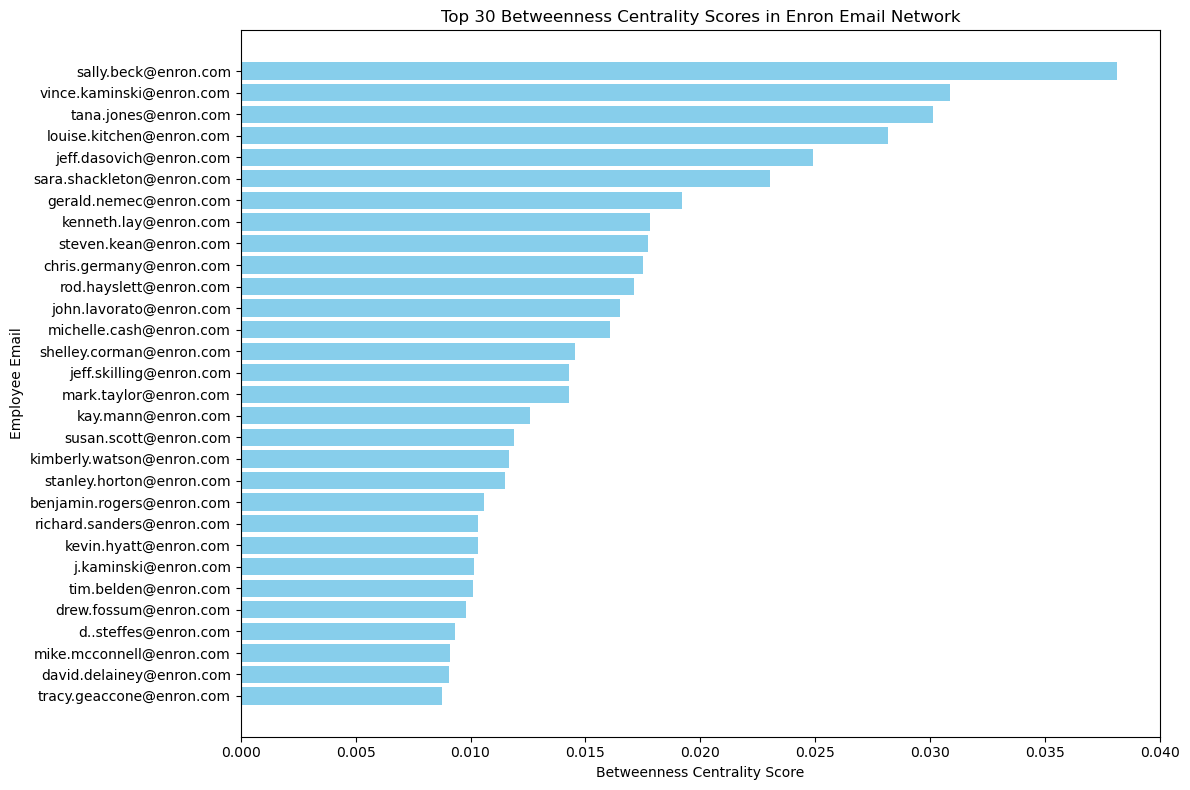

In [21]:
# Sort and print the top 30 individuals by betweenness centrality
sorted_betweenness = sorted(betweenness_centrality.items(), key=lambda x: x[1], reverse=True)

# Get the top 30 nodes with the highest betweenness centrality
betweenness_top_30 = sorted_betweenness[:30]

# Extract names and scores for the bar graph
betweenness_names = [x[0] for x in betweenness_top_30]
betweenness_scores = [x[1] for x in betweenness_top_30]

plt.figure(figsize=(12, 8))
plt.barh(betweenness_names, betweenness_scores, color='skyblue')
plt.xlabel('Betweenness Centrality Score')
plt.ylabel('Employee Email')
plt.title('Top 30 Betweenness Centrality Scores in Enron Email Network')
plt.gca().invert_yaxis()
plt.tight_layout()

plt.show()

In [22]:
# Extract email addresses of the top 30
betweenness_top_30_emails = [x[0] for x in betweenness_top_30]

betweenness_email_to_job_title = {}

for email in betweenness_top_30_emails:
    job_title = data.loc[data['From'] == email, 'Job_Title'].drop_duplicates().values
    if len(job_title) > 0:
        betweenness_email_to_job_title[email] = job_title[0]
    else:
        betweenness_email_to_job_title[email] = 'Unknown'

betweenness_top_30_with_titles = pd.DataFrame(betweenness_top_30, columns=['email', 'between_centrality'])
betweenness_top_30_with_titles['Job_Title'] = betweenness_top_30_with_titles['email'].map(betweenness_email_to_job_title)

betweenness_top_30_with_titles.head(30)

,email,between_centrality,Job_Title
0,sally.beck@enron.com,0.038108,Chief Operating Officer
1,vince.kaminski@enron.com,0.030880,"Manager, Risk Management Head"
2,tana.jones@enron.com,0.030102,Vice President
3,louise.kitchen@enron.com,0.028178,"President, Enron Online"
4,jeff.dasovich@enron.com,0.024900,Government Relation Executive
5,sara.shackleton@enron.com,0.023037,Vice President
6,gerald.nemec@enron.com,0.019187,Vice President
7,kenneth.lay@enron.com,0.017795,CEO
8,steven.kean@enron.com,0.017721,"Vice President, Vice President & Chief of Staff"
9,chris.germany@enron.com,0.017523,Vice President


3. Calculate Closeness Centrality
- <i>Measures how close a node is to all other nodes in the network<i>
- <i>Closeness centrality measures how quickly an individual can communicate with others in the network.<i>
- <i>High closeness - individuals are centrally located in the network, can quickly reach out to others and disseminate information<i>
- <i>Identifies efficient communicators - ideal for broadcasting information or coordinating tasks | often central figures in the network<i>

In [23]:
closeness_centrality = nx.closeness_centrality(G)

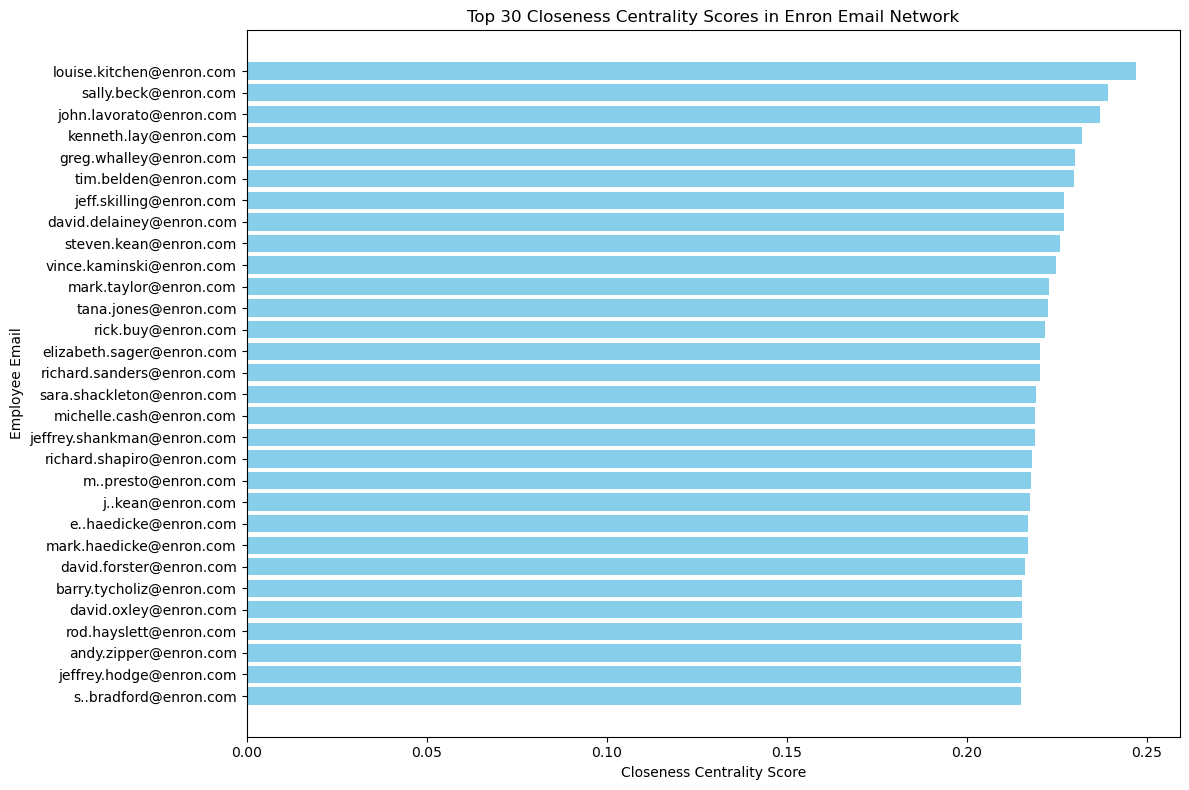

In [24]:
# Sort and print the top 30 individuals by betweenness centrality
sorted_closeness = sorted(closeness_centrality.items(), key=lambda x: x[1], reverse=True)

# Get the top 30 nodes with the highest betweenness centrality
closeness_top_30 = sorted_closeness[:30]

# Extract names and scores for the bar graph
closeness_names = [x[0] for x in closeness_top_30]
closeness_scores = [x[1] for x in closeness_top_30]

plt.figure(figsize=(12, 8))
plt.barh(closeness_names, closeness_scores, color='skyblue')
plt.xlabel('Closeness Centrality Score')
plt.ylabel('Employee Email')
plt.title('Top 30 Closeness Centrality Scores in Enron Email Network')
plt.gca().invert_yaxis()
plt.tight_layout()

plt.show()

In [25]:
# Extract email addresses of the top 30
closeness_top_30_emails = [x[0] for x in closeness_top_30]

closeness_email_to_job_title = {}

for email in closeness_top_30_emails:
    job_title = data.loc[data['From'] == email, 'Job_Title'].drop_duplicates().values
    if len(job_title) > 0:
        closeness_email_to_job_title[email] = job_title[0]
    else:
        closeness_email_to_job_title[email] = 'Unknown'

closeness_top_30_with_titles = pd.DataFrame(closeness_top_30, columns=['email', 'closeness_centrality'])
closeness_top_30_with_titles['Job_Title'] = closeness_top_30_with_titles['email'].map(closeness_email_to_job_title)

closeness_top_30_with_titles.head(30)

,email,closeness_centrality,Job_Title
0,louise.kitchen@enron.com,0.246939,"President, Enron Online"
1,sally.beck@enron.com,0.239299,Chief Operating Officer
2,john.lavorato@enron.com,0.237157,"CEO, Enron America"
3,kenneth.lay@enron.com,0.232038,CEO
4,greg.whalley@enron.com,0.230194,Vice President
5,tim.belden@enron.com,0.229807,Vice President
6,jeff.skilling@enron.com,0.227195,Government Relation Executive
7,david.delainey@enron.com,0.227120,"CEO, Enron North America and Enron Energy Serv..."
8,steven.kean@enron.com,0.225964,"Vice President, Vice President & Chief of Staff"
9,vince.kaminski@enron.com,0.224923,"Manager, Risk Management Head"


Final Thoughts:
- in general, high position employees in Enron are seen - they are very much involved in email communications
- can choose to find out where the "normal" employees reside in the overall rankings

Visualisation Chart of Top 30 Degree Centrality

ValueError: Unable to determine Axes to steal space for Colorbar. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.

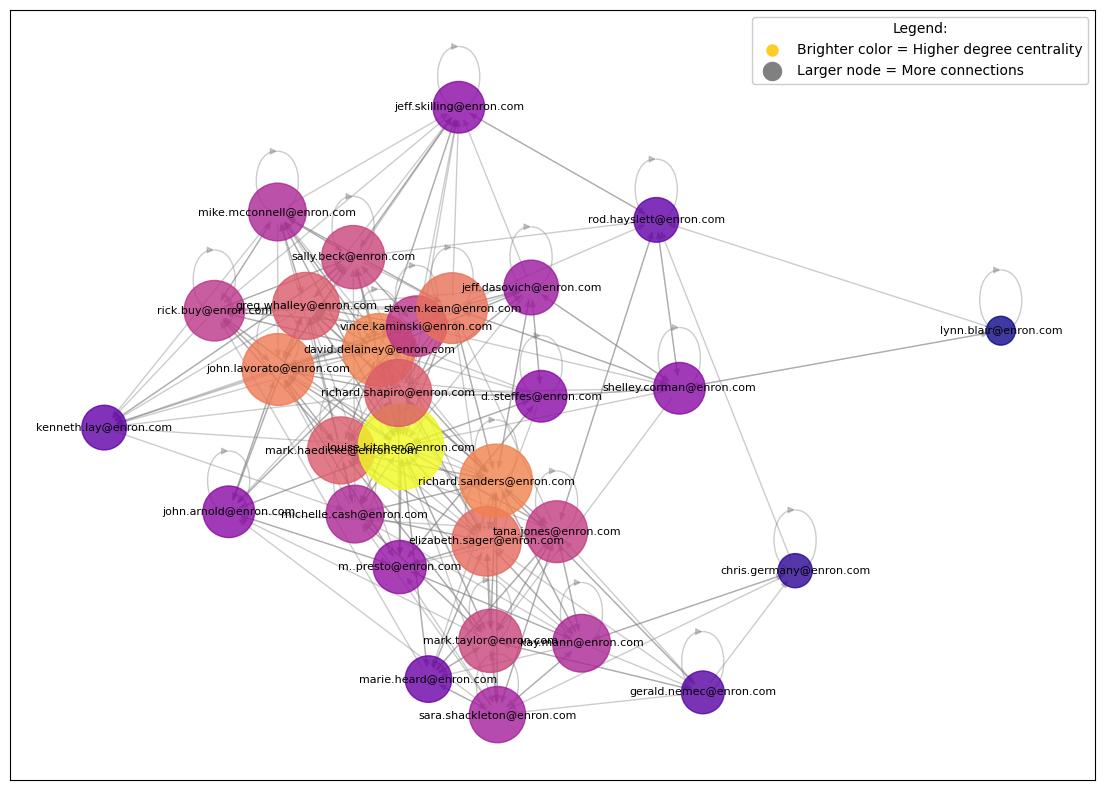

In [32]:
# Get the top 30 employees based on degree centrality
top_30 = sorted(degree_centrality, key=degree_centrality.get, reverse=True)[:30]

# Create a subgraph with the top 30 employees
subgraph = G.subgraph(top_30)

# Calculate degree centrality for the subgraph
subgraph_degree_centrality = nx.degree_centrality(subgraph)

# Set visualization parameters
plt.figure(figsize=(14, 10))
pos = nx.spring_layout(subgraph, seed=42)  # seed for reproducible layout

# Scale node size and color
node_size = [v * 2500 for v in subgraph_degree_centrality.values()]
node_color = [v * 50 for v in subgraph_degree_centrality.values()]

# Draw the network
nodes = nx.draw_networkx_nodes(
    subgraph, pos, 
    node_size=node_size, 
    node_color=node_color, 
    cmap=plt.cm.plasma,
    alpha=0.8
)
nx.draw_networkx_edges(subgraph, pos, edge_color='gray', alpha=0.4)
nx.draw_networkx_labels(subgraph, pos, font_size=8, font_color='black')

# Create custom legend
legend_elements = [
    plt.Line2D([0], [0], 
              marker='o', 
              color='w', 
              label='Brighter color = Higher degree centrality',
              markerfacecolor=plt.cm.plasma(0.9),
              markersize=10),
    plt.Line2D([0], [0], 
              marker='o', 
              color='w', 
              label='Larger node = More connections',
              markerfacecolor='gray',
              markersize=15)
]

# Add legend to plot
plt.legend(handles=legend_elements, 
           loc='upper right',
           framealpha=1,
           title='Legend:',
           title_fontsize=10)

# Add colorbar
sm = plt.cm.ScalarMappable(
    cmap=plt.cm.plasma, 
    norm=plt.Normalize(vmin=min(subgraph_degree_centrality.values()), 
                       vmax=max(subgraph_degree_centrality.values()))
)
sm.set_array([])
cbar = plt.colorbar(sm, shrink=0.8)
cbar.set_label('Degree Centrality Score', fontsize=10)

# Explicit title command with show()
plt.title('Top 30 Degree Centrality', fontsize=14, pad=20, y=1.05)  # y parameter lifts title higher
plt.axis('off')

# Ensure tight layout and show
plt.tight_layout()
plt.show()

Mapping to top NER
- jeff - found 2
- chris - found
- vince - found
- john - found 2
- mike - found

In [33]:
print("jeff.dasovich@enron.com: " + data[data["From"] == "jeff.dasovich@enron.com"]["Job_Title"].unique()) #'Government Relation Executive'
print("jeff.skilling@enron.com: " + data[data["From"] == "jeff.skilling@enron.com"]["Job_Title"].unique()) #'Government Relation Executive'
print("chris.germany@enron.com: " + data[data["From"] == "chris.germany@enron.com"]["Job_Title"].unique()) #'Vice President'
print("vince.kaminski@enron.com: " + data[data["From"] == "vince.kaminski@enron.com"]["Job_Title"].unique()) #'Vice President'
print("john.lavorato@enron.com: " + data[data["From"] == "john.lavorato@enron.com"]["Job_Title"].unique()) #'CEO, Enron America'
print("john.arnold@enron.com: " + data[data["From"] == "john.arnold@enron.com"]["Job_Title"].unique()) #'Vice President'
print("mike.mcconnell@enron.com: " + data[data["From"] == "mike.mcconnell@enron.com"]["Job_Title"].unique()) #'Vice President'


['jeff.dasovich@enron.com: Government Relation Executive']
['jeff.skilling@enron.com: Government Relation Executive']
['chris.germany@enron.com: Vice President']
['vince.kaminski@enron.com: Manager, Risk Management Head']
['john.lavorato@enron.com: CEO, Enron America']
['john.arnold@enron.com: Vice President']
['mike.mcconnell@enron.com: Vice President']


mapping with labels for top few degree centrality (from)
- labels of email content they sent

In [9]:
def get_labels_by_email(df, email):
    # Filter rows for the given email
    email_data = df[df['From'] == email]
    
    # Count occurrences of each label
    label_counts = email_data['Label'].value_counts().reset_index()
    label_counts.columns = ['Label', 'count']
    
    # Sort by count in descending order
    label_counts = label_counts.sort_values('count', ascending=False)
    
    return label_counts


In [13]:
email = 'tana.jones@enron.com'
result = get_labels_by_email(data, email)
print('Employee email: tana.jones@enron.com')
print(result)

Employee email: tana.jones@enron.com
                                               Label  count
0                   Energy Trading & Legal Contracts   6421
1                      Casual/Internal Email Chatter   1000
2             Corporate Strategy, Risk, & Operations    537
3           Energy Market & State-Level Power Issues    105
4                Internal Communications & Personnel     94
5  Regulatory & Infrastructure (FERC, ISO, Transm...     10


In [ ]:
email = 'sara.shackleton@enron.com'
result = get_labels_by_email(data, email)
print('Employee email: sara.shackleton@enron.com')
print(result)

Employee email: sara.shackleton@enron.com
                                               Label  count
0                   Energy Trading & Legal Contracts   7010
1                      Casual/Internal Email Chatter    902
2             Corporate Strategy, Risk, & Operations    540
3                Internal Communications & Personnel    129
4           Energy Market & State-Level Power Issues     56
5  Regulatory & Infrastructure (FERC, ISO, Transm...     15


In [25]:
email = 'sally.beck@enron.com'
result = get_labels_by_email(data, email)
print('Employee email: sally.beck@enron.com')
print(result)

Employee email: sally.beck@enron.com
                                      Label  count
0    Corporate Strategy, Risk, & Operations   2091
1             Casual/Internal Email Chatter   1452
2       Internal Communications & Personnel    686
3          Energy Trading & Legal Contracts     84
4  Energy Market & State-Level Power Issues      2


mapping with labels for top-3 degree centrality (to)
- labels of email content they received

In [18]:
def get_labels_by_email_to(df, email):
    # Filter rows for the given email
    email_data = df[df['To'] == email]
    
    # Count occurrences of each label
    label_counts = email_data['Label'].value_counts().reset_index()
    label_counts.columns = ['Label', 'count']
    
    # Sort by count in descending order
    label_counts = label_counts.sort_values('count', ascending=False)
    
    return label_counts


In [20]:
email_to_1 = 'tana.jones@enron.com'
result_to_1 = get_labels_by_email_to(filtered_data_2, email_to_1)
print('Employee email: tana.jones@enron.com')
print(result_to_1)

Employee email: tana.jones@enron.com
                                               Label  count
0                   Energy Trading & Legal Contracts   4989
1                      Casual/Internal Email Chatter    550
2             Corporate Strategy, Risk, & Operations    402
3                Internal Communications & Personnel     73
4           Energy Market & State-Level Power Issues     28
5  Regulatory & Infrastructure (FERC, ISO, Transm...     14


In [21]:
email_to_2 = 'sara.shackleton@enron.com'
result_to_2 = get_labels_by_email_to(filtered_data_2, email_to_2)
print('Employee email: sara.shackleton@enron.com')
print(result_to_2)

Employee email: sara.shackleton@enron.com
                                               Label  count
0                   Energy Trading & Legal Contracts   4281
1                      Casual/Internal Email Chatter    560
2             Corporate Strategy, Risk, & Operations    399
3           Energy Market & State-Level Power Issues     78
4                Internal Communications & Personnel     75
5  Regulatory & Infrastructure (FERC, ISO, Transm...     13


In [24]:
email_to_3 = 'sally.beck@enron.com'
result_to_3 = get_labels_by_email_to(filtered_data_2, email_to_3)
print('Employee email: sally.beck@enron.com')
print(result_to_3)

Employee email: sally.beck@enron.com
                                               Label  count
0             Corporate Strategy, Risk, & Operations   2568
1                      Casual/Internal Email Chatter    672
2                Internal Communications & Personnel    412
3                   Energy Trading & Legal Contracts    264
4           Energy Market & State-Level Power Issues     25
5  Regulatory & Infrastructure (FERC, ISO, Transm...      4
